# MDC 018 - Projeto Final

In [1]:
import pandas as pd

# Carregando os dados de treinamento e teste
train_critic = pd.read_csv("train_critic.csv")

test_critic = pd.read_csv("test_critic.csv")

In [2]:
train_critic

,Show,Sentiment,Review
0,Bodyguard,1,"This has been a brilliant, compulsive, five-st..."
1,Mad Men,0,"With each new season, I try to remind myself t..."
2,1971: The Year That Music Changed Everything,1,Here's one of the most all-encompassing and st...
3,Six Feet Under,1,"To me, it was one of the most clever, funny, s..."
4,Pieces of Her,0,"Well acted and highly suspenseful, the eight-p..."
...,...,...,...
11827,Freaks and Geeks,1,Freaks and Geeks boasts an extremely talented ...
11828,The Gilded Age,1,It's a period piece set in 1882 New York that ...
11829,Joe vs Carole,1,McKinnon and her co-producers must be credited...
11830,Rick and Morty,1,"As season openers go, this is a really solid e..."


Verificação de balanceamento:

In [3]:
train_critic['Sentiment'].value_counts()


Sentiment
1    9995
0    1837
Name: count, dtype: int64

Ambos conjuntos estão fortemente desbalanceados.

# Predição de sentimento

Conjunto train_critic

In [4]:
# Separação entre conjunto de treino e validação
from sklearn.model_selection import train_test_split

# Remove NAs
train_critic.dropna(subset=['Review'], inplace=True)

(train_critic_df, val_critic_df) = train_test_split(train_critic, test_size=0.2)
train_critic_df['Sentiment'].value_counts()

Sentiment
1    7997
0    1467
Name: count, dtype: int64

In [5]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Calcular os pesos para as classes
classes = train_critic['Sentiment'].unique()
weights = compute_class_weight(
    class_weight='balanced',
    classes=np.array(classes),
    y=train_critic['Sentiment']
)

class_weights = dict(zip(classes, weights))
class_weights

{1: 0.5918459229614808, 0: 3.221949891067538}

In [6]:
val_critic_texts = val_critic_df["Review"].tolist()
val_critic_labels = val_critic_df["Sentiment"].tolist()

In [7]:
from sklearn.metrics import balanced_accuracy_score
from transformers import pipeline
import matplotlib.pyplot as plt

def get_balanced_accuracy(model, tokenizer, texts, labels):
    classifier = pipeline("text-classification", model=model, tokenizer=tokenizer)
    predictions = []

    for text in texts:
        result = classifier(text)
        label = int(result[0]["label"].split("_")[-1])
        predictions.append(label)
    return round(float(balanced_accuracy_score(labels, predictions)),2)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


def plot_confusion_matrix(trainer, dataset, label_names=None, cmap="Blues"):
    predictions_output = trainer.predict(dataset)
    logits = predictions_output.predictions
    labels = predictions_output.label_ids
    predictions = logits.argmax(axis=-1)
    cm = confusion_matrix(labels, predictions,  normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
    disp.plot(cmap=cmap, values_format=".2f")
    plt.show()
    return cm

C:\Users\p.moura\.virtualenvs\mdc-projeto-final\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
from transformers import RobertaForSequenceClassification, RobertaTokenizer, Trainer, TrainingArguments
from sklearn.utils.class_weight import compute_class_weight
import torch
import numpy as np
from datasets import Dataset
from sklearn.metrics import balanced_accuracy_score

# Checkpoint do modelo RoBERTa-Tiny (arampacha/roberta-tiny)
model_name = "distilbert/distilroberta-base"  # Checkpoint RoBERTa-Tiny
num_labels = 2  # Número de classes no seu problema

# Carregando o modelo e tokenizer RoBERTa-Tiny
model = RobertaForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
tokenizer = RobertaTokenizer.from_pretrained(model_name)

# Supondo que 'labels' contenha todos os rótulos do conjunto de treinamento
labels = train_critic['Sentiment']  # Altere para acessar os rótulos no seu dataset

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilbert/distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(labels), y=labels)
class_weights = torch.tensor(class_weights, dtype=torch.float)  # Converta para um tensor PyTorch
import torch.nn as nn

#tokeniza os datasets
train_encodings = tokenizer(train_critic_df['Review'].tolist(), truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(list(val_critic_df['Review']), truncation=True, padding=True, max_length=128)

In [10]:
class CustomTrainer(Trainer):
    def __init__(self, class_weights, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        # Define a função de perda com os pesos de classe
        loss_fct = nn.CrossEntropyLoss(weight=self.class_weights.to(logits.device))
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

In [11]:
import evaluate
from sklearn.metrics import balanced_accuracy_score

metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = metric.compute(predictions=predictions, references=labels)
    return accuracy

def compute_metrics_balanced(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    # Calcular acurácia balanceada
    balanced_acc = balanced_accuracy_score(labels, predictions)

    return {"balanced_accuracy": balanced_acc}

In [ ]:
training_args = TrainingArguments(
    output_dir="./results_critic_distilroberta",
    learning_rate=5e-5,
    num_train_epochs=8,
    weight_decay=0.01,
    logging_dir="./logs",
    eval_strategy="epoch",
    load_best_model_at_end=True,               # Carregar o melhor modelo ao final
    metric_for_best_model="balanced_accuracy", # Métrica para determinar o melhor modelo
    save_strategy="epoch",                     # Salvar checkpoints no final de cada época
    save_total_limit=1,                        # Limitar os checkpoints a 1 para economizar espaço
    greater_is_better=True                     # Se maior métrica significa melhor modelo
)
train_critic_dataset = Dataset.from_dict({
    'input_ids': train_encodings['input_ids'],
    'attention_mask': train_encodings['attention_mask'],
    'labels': list(train_critic_df['Sentiment'])
})

val_critic_dataset = Dataset.from_dict({
    'input_ids': val_encodings['input_ids'],
    'attention_mask': val_encodings['attention_mask'],
    'labels': list(val_critic_df['Sentiment'])
})

trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_critic_dataset,
    eval_dataset=val_critic_dataset,
    class_weights=class_weights,
    compute_metrics=compute_metrics_balanced
)
trainer.train()

Epoch,Training Loss,Validation Loss


In [13]:
get_balanced_accuracy(model, tokenizer, val_critic_texts, val_critic_labels)

0.83

In [14]:
trainer.evaluate()

{'eval_loss': 0.512459933757782,
 'eval_balanced_accuracy': 0.8300887158295313,
 'eval_runtime': 47.6275,
 'eval_samples_per_second': 49.698,
 'eval_steps_per_second': 6.215,
 'epoch': 8.0}

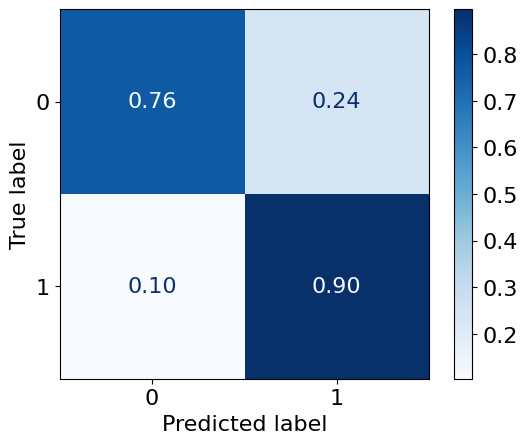

array([[0.76347305, 0.23652695],
       [0.10329562, 0.89670438]])

In [30]:
plot_confusion_matrix(trainer,val_critic_dataset)

# Teste

In [16]:
test_critic_texts = test_critic["Review"].tolist()
test_critic_labels = test_critic["Sentiment"].tolist()
get_balanced_accuracy(model, tokenizer, test_critic_texts, test_critic_labels)

0.82

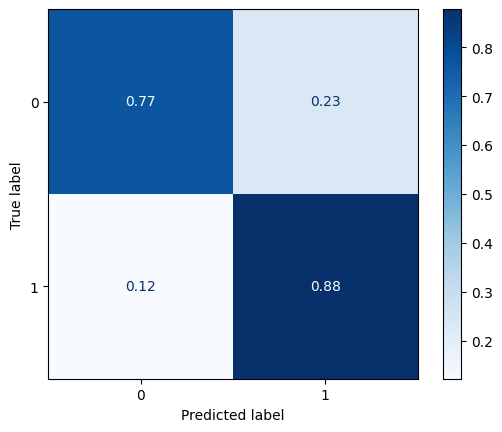

array([[0.76837416, 0.23162584],
       [0.12191235, 0.87808765]])

In [17]:
test_encodings = tokenizer(list(test_critic['Review']), truncation=True, padding=True, max_length=128)
test_critic_dataset = Dataset.from_dict({
    'input_ids': test_encodings['input_ids'],
    'attention_mask': test_encodings['attention_mask'],
    'labels': list(test_critic['Sentiment'])
})
plot_confusion_matrix(trainer,test_critic_dataset)